### Overview
This notebook reads a pre-processed set of **English questions** from Kenyan farmers, selects questions on **cattle**;   
tokenizes words, removes stopwords, and lemmatizes; creates bi-and tri-grams and network visualizations

### Inputs: (files saved to your working directory)
* CSV file of cleaned / lower case /  punctuation removed questions: 'kenya_eng_q_clean.csv'
* created by *question_preprocess.ipynb* --> *kenya-q_eng.ipynb* notebook code

### Output files (in working directory)
* CSV file of top 500 n-grams: 'ken_eng_{bi,tri,quad} grams_top500_cattle.csv'
* HTML file of interactive network diagram of top 40 bigrams: '40bigram_eng_ken_cattle_network.html'                                     
* HTML file of interactive network diagram of top 40 trigrams: '40trigram_eng_ken_cattle_network.html'
* PNG file of word frequency graphs:  'top20{bi, tri, quad}grams_ken_cattle_eng.png'
                                         
### Steps:
1. Select questions topic == 'cattle'
2. Tokenize - takes ~ 3 min to run
3. Remove stopwords & lemmatise verbs and nouns
4. Create english bigrams, trigrams, & quadgrams; save as csv files
5. Plot frequency distribution of top 20 bigrams, trigrams
6. Plot & save interactive network graphs of top 40 bigrams and trigrams
7. Save top 500 bi- and tri- grams in CSV files
                                                                                                                                                                       
### Local Variables (partial list):
* q_df       
* ken_q_list
* ken_eng_tokens
* all_bigrams
* all_trigrams
* bigram_freq
* unigram_freq                                          
* trigram_freq
                                                                                                                                                                                                    

In [ ]:
#import packages:  pandas, numpy,nltk, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import string
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

#first - pyvis install in conda prompt: 'conda install conda-forge::pyvis'
from pyvis.network import Network

from collections import Counter

from IPython.display import HTML, display, IFrame


In [2]:
#load processed country question file
q_df = pd.read_csv('kenya_eng_q_clean.csv')
q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384774 entries, 0 to 1384773
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1384774 non-null  int64 
 1   question_id     1384774 non-null  int64 
 2   question_topic  1083079 non-null  object
 3   question_clean  1384774 non-null  object
dtypes: int64(2), object(2)
memory usage: 42.3+ MB


In [3]:
#select questions with topic = 'cattle':

eng_kenya_df=q_df.loc[(q_df['question_topic'] == 'cattle'),['question_id', 'question_topic', 'question_clean']]
len(eng_kenya_df)
#eng_kenya_df = clean_df.loc[(clean_df['question_topic'] != ''),['question_clean']]
eng_kenya_df.head()


,question_id,question_topic,question_clean
10,3850404,cattle,how do we milk a sick cow
16,3850591,cattle,for how long does a cow needs to rest during ...
30,3851366,cattle,what is the importans of feeding cows with dr...
66,3853226,cattle,which is the best suppliment milk to the calf
82,3853857,cattle,what are non_chemical methods of controlling ...


In [5]:
print("the number of english cattle questions: ", len(eng_kenya_df))

the number of english cattle questions:  164312


In [4]:
#create list of questions to be tokenized:
ken_q_list=list(eng_kenya_df['question_clean'])
print(ken_q_list[0:5])


['  how  do  we  milk  a   sick  cow ', ' for how long does a cow needs to rest during the night ', ' what is the importans of feeding cows with dry feeds', ' which is the  best  suppliment milk to the calf', ' what are non_chemical methods of controlling ticks in cattle']


In [6]:
# define function to tokenize, normalize verbs & nouns ... with help from ChatGPT

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# map POS tags to WordNet's POS
def get_wordnet_pos(tag):
    if tag.startswith('N'): 
        return wordnet.NOUN
    elif tag.startswith('V'): 
        return wordnet.VERB
    elif tag.startswith('J'): 
        return wordnet.ADJ
    elif tag.startswith('R'): 
        return wordnet.ADV
    else:
        return None

def normalize_strings_list(strings_list):
    """
    Input: list of strings, already lower-case
    Output: list of normalized token lists
    """

    normalized = []

    for text in strings_list:
        # tokenize
        tokens = word_tokenize(text)

        # remove stopwords and non-alphabetic tokens
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]

        # pos-tag tokens
        tags = pos_tag(tokens)

        # lemmatize nouns (plural→singular), verbs (tense normalization), etc.
        lemmatized = []
        for word, tag in tags:
            wn_pos = get_wordnet_pos(tag)
            if wn_pos:
                lemma = lemmatizer.lemmatize(word, wn_pos)
            else:
                lemma = lemmatizer.lemmatize(word)
            lemmatized.append(lemma)

        normalized.append(lemmatized)

    return normalized



In [7]:
#test this function
text = {"chickens are eating grains"}
print(normalize_strings_list(text))


[['chicken', 'eat', 'grain']]


In [8]:
ken_eng_tokens = normalize_strings_list(ken_q_list)
print(ken_eng_tokens[0:5])
print("Number of tokens: ", len(ken_eng_tokens))

[['milk', 'sick', 'cow'], ['long', 'cow', 'need', 'rest', 'night'], ['importans', 'feed', 'cow', 'dry', 'feed'], ['best', 'suppliment', 'milk', 'calf'], ['method', 'control', 'tick', 'cattle']]
Number of tokens:  164312


In [9]:
#create list of bigrams:
all_bigrams = []

for question in ken_eng_tokens:
    #create bigrams iterator for each element of tokens: ken_eng_tokens.csv
    bigram_iterator = bigrams(question)
    bigram_list = list(bigram_iterator)

    # Add the bigrams of the current question to the overall list
    all_bigrams.extend(bigram_list)

In [10]:
#create list of trigrams, if # tokens >= 3
all_trigrams = []

for question in ken_eng_tokens:
    if len(question) < 3:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_trigrams.extend(list(trigrams(question)))


In [11]:
print("# of trigrams: ", len(all_trigrams))
print(all_trigrams[0:5])
type(all_trigrams)

# of trigrams:  721341
[('milk', 'sick', 'cow'), ('long', 'cow', 'need'), ('cow', 'need', 'rest'), ('need', 'rest', 'night'), ('importans', 'feed', 'cow')]


list

In [12]:
print("# of bigrams: ", len(all_bigrams))
print(all_bigrams[0:5])
type(all_bigrams)

# of bigrams:  885432
[('milk', 'sick'), ('sick', 'cow'), ('long', 'cow'), ('cow', 'need'), ('need', 'rest')]


list

In [13]:
bigram_freq = Counter(all_bigrams)
#type(bigram_freq)

In [14]:
trigram_freq = Counter(all_trigrams)
#type(trigram_freq)

In [ ]:
### Bigram Visualizations:  Note - drop "reply, response" and "follow, response"  bigrams (index = 5,6)

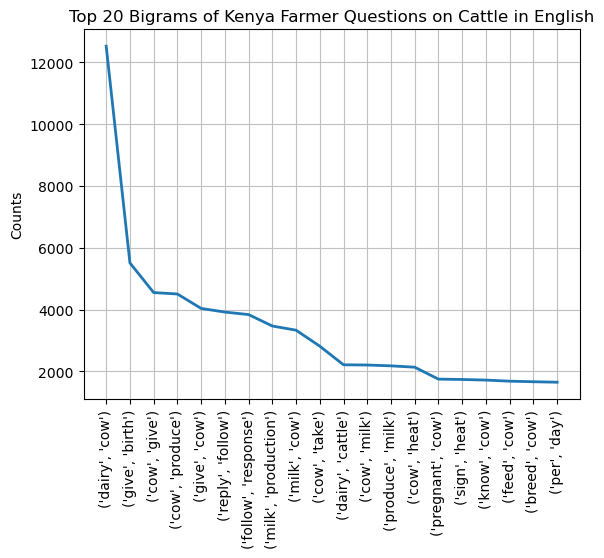

In [15]:
#plot frequency distribution of bigrams
fdist = FreqDist(all_bigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Bigrams of Kenya Farmer Questions on Cattle in English")
plt.xlabel("") 
plt.savefig("top20bigrams_cattle_ken_eng.png", bbox_inches='tight')

In [16]:
#unigram counts for node-size based on token frequency:
 
unigram_freq = Counter(tok for tokens in ken_eng_tokens for tok in tokens)
print(unigram_freq.most_common(75))

[('cow', 120273), ('milk', 26357), ('dairy', 25082), ('give', 20297), ('calf', 17284), ('best', 16524), ('cattle', 15391), ('feed', 10851), ('problem', 10236), ('use', 9935), ('bull', 9039), ('get', 8858), ('heat', 8541), ('month', 8034), ('produce', 8025), ('birth', 7560), ('cause', 7543), ('many', 7531), ('breed', 7443), ('take', 7255), ('good', 7070), ('salt', 7008), ('type', 6893), ('one', 6844), ('ask', 6834), ('long', 6579), ('day', 6310), ('production', 5460), ('sign', 5116), ('time', 4965), ('heifer', 4592), ('pregnant', 4587), ('follow', 4360), ('reply', 4310), ('know', 4281), ('deworm', 4205), ('medicine', 4015), ('response', 3909), ('want', 3900), ('disease', 3895), ('need', 3830), ('farmer', 3626), ('make', 3609), ('keep', 3485), ('serve', 3382), ('eat', 3283), ('could', 3249), ('start', 3067), ('help', 2983), ('show', 2894), ('much', 2826), ('might', 2768), ('water', 2767), ('like', 2678), ('skin', 2660), ('food', 2644), ('treat', 2581), ('farm', 2556), ('two', 2515), ('ca

In [21]:
#confirm slicing of 2 bigrams:  
#print(bigram_freq.most_common()[:5], bigram_freq.most_common()[7:42])
test=bigram_freq.most_common(42)
del test[5]
del test[5]
print(test[0:10])

[(('dairy', 'cow'), 12521), (('give', 'birth'), 5509), (('cow', 'give'), 4550), (('cow', 'produce'), 4504), (('give', 'cow'), 4037), (('milk', 'production'), 3468), (('milk', 'cow'), 3333), (('cow', 'take'), 2815), (('dairy', 'cattle'), 2213), (('cow', 'milk'), 2206)]


In [25]:
#create interactive directed network chart...with help from Anaconda toolbox

# Variables:
# - bigram_freq: Counter object with bigram frequencies (ranging from ~900 to 13000)
# - unigram_freq: Counter object with country unigram frequencies (up to ~ 120000)

# Get top 40 bigrams, excluding the 5th and 6th:  
top_n = 40
top_bigrams = bigram_freq.most_common(top_n+2)
del top_bigrams[5]
del top_bigrams[5]
 
# Create a graph
G = nx.DiGraph()

# Add edges (bigrams) with weights based on frequency
for bigram, frequency in top_bigrams:
    word1, word2 = bigram
    G.add_edge(word1, word2, value=frequency, title=f"Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the bigrams
all_words = set()
for bigram, _ in top_bigrams:
    all_words.add(bigram[0])
    all_words.add(bigram[1])

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 10000)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency) / (120000)
    ) if frequency >= 10000 else min_node_size
    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="black")
net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Add edge thickness based on bigram frequency

for edge in net.edges:
    # Scale edge width based on weight
   weight = edge['value']
    # Map from range [900, 13000] to [1, 10] for edge width
   edge['width'] = 1 + 9 * ((weight - 900) / (13000 - 900)) if weight >= 900 else 1
   edge['title'] = f"Frequency: {weight}"

    # Improve arrow visibility
   edge['arrows'] = 'to'
   edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}  # Curved edges for better visibility
   edge['color'] = {'opacity': 0.5} 
    
# Add some color to distinguish nodes
subdued_colors = [
    '#7D9D9C', '#576F72', '#8B9A46', '#A4BE7B', '#5F7161', 
    '#6D8B74', '#94B49F', '#B4CFB0', '#9CB4CC', '#748DA6',
    '#6096B4', '#93BFCF', '#BDCDD6', '#9F73AB', '#A084DC'
]

for i, node in enumerate(net.nodes):
     node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
     node['color'] = subdued_colors[i % len(subdued_colors)]
     node['borderWidth'] = 2
     node['borderWidthSelected'] = 4


# Save the HTML file with the title and legend included
filename = "40bigram_eng_ken_cattle_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Bigrams from Kenyan Farmer Questions on Cattle on English</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = bigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

# Display in notebook
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40bigram_eng_ken_cattle_network.html'


### Trigram Visualizations:  Note - most frequent trigram isn't informative, so should be dropped

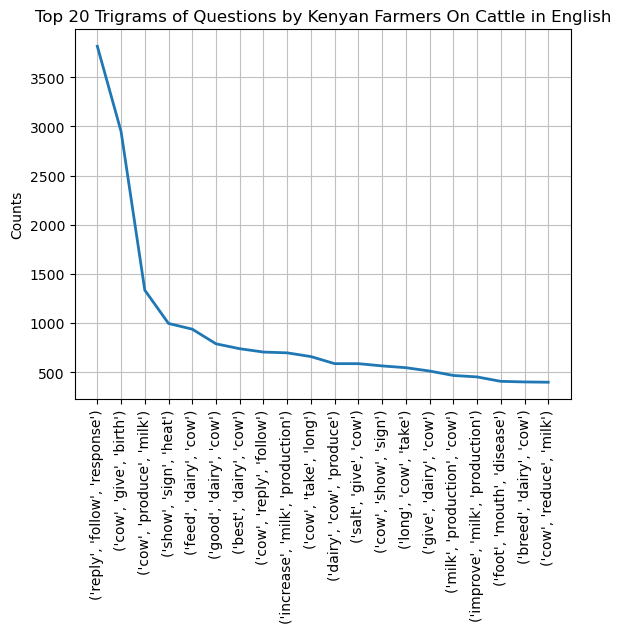

In [26]:
#plot frequency distribution of trigrams
fdist = FreqDist(all_trigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Trigrams of Questions by Kenyan Farmers On Cattle in English")
plt.xlabel("") 
plt.savefig("top20trigrams_cattle_ken_eng.png", bbox_inches='tight')

In [27]:
#interactive directed network graph of top 30 trigrams...with help from Anaconda Assistant

# Input variables:
# - trigram_freq: Counter object with trigram frequencies (ranging from 200 to 3000)
# - unigram_freq: Counter object with unigram frequencies (up to 120000)

#choose most frequent N bigrams, after dropping 1st trigram:
top_n = 40
top_trigrams = trigram_freq.most_common()[1:top_n+1]

# Create a directed graph
G = nx.DiGraph()

# For trigrams, we'll create a path: word1 -> word2 -> word3
for trigram, frequency in top_trigrams:
    word1, word2, word3 = trigram
    
    # Add edges with weights based on frequency
    G.add_edge(word1, word2, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")
    G.add_edge(word2, word3, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the trigrams
all_words = set()
for trigram, _ in top_trigrams:
    all_words.update(trigram)

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 10000)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency - 10000) / (120000 - 10000)
    ) if frequency >= 10000 else min_node_size

    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network with directed edges
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="#333333", directed=True)
net.heading = ""

net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Subtle color palette
subtle_colors = [
    '#E6E6FA', '#D8BFD8', '#DDA0DD', '#EE82EE', '#DA70D6',
    '#BA55D3', '#9370DB', '#8A2BE2', '#9400D3', '#9932CC',
    '#8B008B', '#800080', '#4B0082', '#6A5ACD', '#483D8B',
    '#7B68EE', '#0000FF', '#0000CD', '#00008B', '#000080'
]

# Add edge thickness based on trigram frequency and make arrows somewhat opaque
for edge in net.edges:
    freq = edge['value']
    # Map from range [200, 3000] to [1, 8] for edge width
    edge['width'] = 1 + 7 * ((freq - 200) / (3000 - 200)) if freq >= 200 else 1
    edge['title'] = f"Frequency: {freq}"
    
    # Somewhat opaque curved arrows
    edge['color'] = {'color': '#848484', 'opacity': 0.5}  # 50% opacity
    edge['arrows'] = {'to': {'enabled': True, 'scaleFactor': 0.6}}
    edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}

# Enhance node appearance with bold labels and subtle colors
for i, node in enumerate(net.nodes):
    node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
    node['color'] = subtle_colors[i % len(subtle_colors)]
    node['borderWidth'] = 2
    node['borderWidthSelected'] = 4

# Save the HTML file with the title and legend included
filename = "40trigram_eng_ken_cattle_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Trigrams from Kenyan Farmers Questions on Cattle in English</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = trigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

#display in notebook:
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40trigram_eng_ken_cattle_network.html'


### Save top 500 bigrams, trigrams to CSV files; plot top 40 quadgrams -- not that informative

In [28]:
#find top 500 bigrams:
top_500 = bigram_freq.most_common(500)
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))

In [29]:
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))
ken_bigrams_500_df.head()

,bigram,count,bigram_str
0,"(dairy, cow)",12521,dairy_cow
1,"(give, birth)",5509,give_birth
2,"(cow, give)",4550,cow_give
3,"(cow, produce)",4504,cow_produce
4,"(give, cow)",4037,give_cow


In [30]:
#save in csv file:
ken_bigrams_500_df.to_csv('ken_eng_bigrams_cattle_top500.csv')


In [31]:
#find top 500 trigrams:
top_500 = trigram_freq.most_common(500)
#convert top_500 list to df, and join trigrams with '_' as separators for later translation, note: there are no duplicates
ken_trigrams_500_df = pd.DataFrame(top_500, columns=['trigram','count'])
ken_trigrams_500_df["trigram_str"] = ken_trigrams_500_df["trigram"].apply(lambda t: "_".join(t))
ken_trigrams_500_df.head()

,trigram,count,trigram_str
0,"(reply, follow, response)",3816,reply_follow_response
1,"(cow, give, birth)",2949,cow_give_birth
2,"(cow, produce, milk)",1334,cow_produce_milk
3,"(show, sign, heat)",995,show_sign_heat
4,"(feed, dairy, cow)",937,feed_dairy_cow


In [32]:
#save in csv file:
ken_trigrams_500_df.to_csv('ken_eng_trigrams_cattle_top500.csv')


In [33]:
#create list of quadgrams, after checking # tokens >= 4
#from nltk.util import ngrams

all_quadgrams = []

for question in ken_eng_tokens:
    if len(question) < 4:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_quadgrams.extend(list(ngrams(question,4)))
        


In [34]:
print("# of quadgrams: ", len(all_quadgrams))


# of quadgrams:  560668


In [35]:
quadgram_freq = Counter(all_quadgrams)

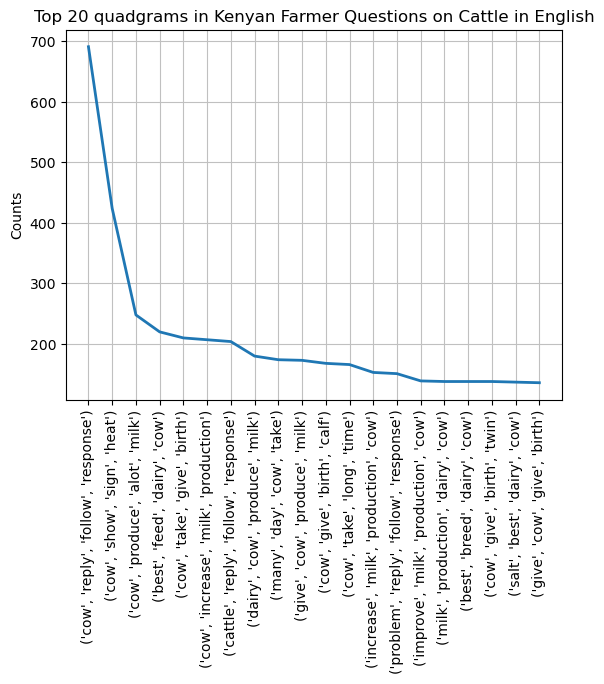

In [36]:
#top 20 quadgram plot

fdist = FreqDist(all_quadgrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} quadgrams in Kenyan Farmer Questions on Cattle in English")
plt.xlabel("") 
plt.savefig("top20quadgrams_ken_cattle_eng.png", bbox_inches='tight')

In [37]:
#find top 500 quadgrams:
top_500 = quadgram_freq.most_common(500)
#convert top_500 list to df, and join quadgrams with '_' as separators for later translation, note: there are no duplicates
ken_quadgrams_500_df = pd.DataFrame(top_500, columns=['quadgram','count'])
ken_quadgrams_500_df["quadgram_str"] = ken_quadgrams_500_df["quadgram"].apply(lambda t: "_".join(t))

In [38]:
#save in csv file:
ken_quadgrams_500_df.to_csv('ken_eng_quadgrams_cattle_top500.csv')